In [1]:
import os
import h5py
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score
from scipy.io import loadmat
from sklearn.linear_model import Ridge

# circuitmap imports
import circuitmap as cm
from circuitmap.simulation import simulate_continuous_experiment
from circuitmap import NeuralDemixer, viz

/home/mat2245/.conda/envs/cuda11/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_ridge_waveforms(psc, model, stim_matrix):
    cnx = np.where(model['mu'])[0]
    locs = np.unique(np.concatenate(np.array([np.where(stim_matrix[n])[0] for n in cnx])))
    lr = Ridge(fit_intercept=False, alpha=1e-3, positive=True, solver='lbfgs')
    lr.fit(model['lam'][cnx][:, locs].T, psc[locs])
    return lr.coef_.T

In [3]:
# Plotting parameters
pA = 1000
ms = 20
stim_reps = 30
ymin = -0.02  * pA
xs = np.arange(-5*ms, 40*ms)
xticks = np.arange(-5*ms, 41*ms, 5*ms)
xticklabels = ['' for _ in range(10)]
xticklabels[1] = 0
xticklabels[-1] = 40
xticklabels[5] = 20

In [4]:
fontsize = 14

### Import data and demixer

In [5]:
demix = NeuralDemixer('../../circuitmap/demixers/nwd_ie_ChroME2f.ckpt', device='cpu')

Lightning automatically upgraded your loaded checkpoint from v1.5.9 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../circuitmap/demixers/nwd_ie_ChroME2f.ckpt`


In [6]:
f = loadmat('test_experimental_data.mat')

In [21]:
stimulus_matrix = np.array(f['stimulus_matrix']).astype(float)
pscs = np.array(f['pscs'])
N = stimulus_matrix.shape[0]
targets = np.array(f['targets'])
depths = np.unique(targets[:, -1])

In [22]:
pscs_demixed = demix(pscs)

Demixing PSC traces... complete (elapsed time 16.35s, device=cpu).


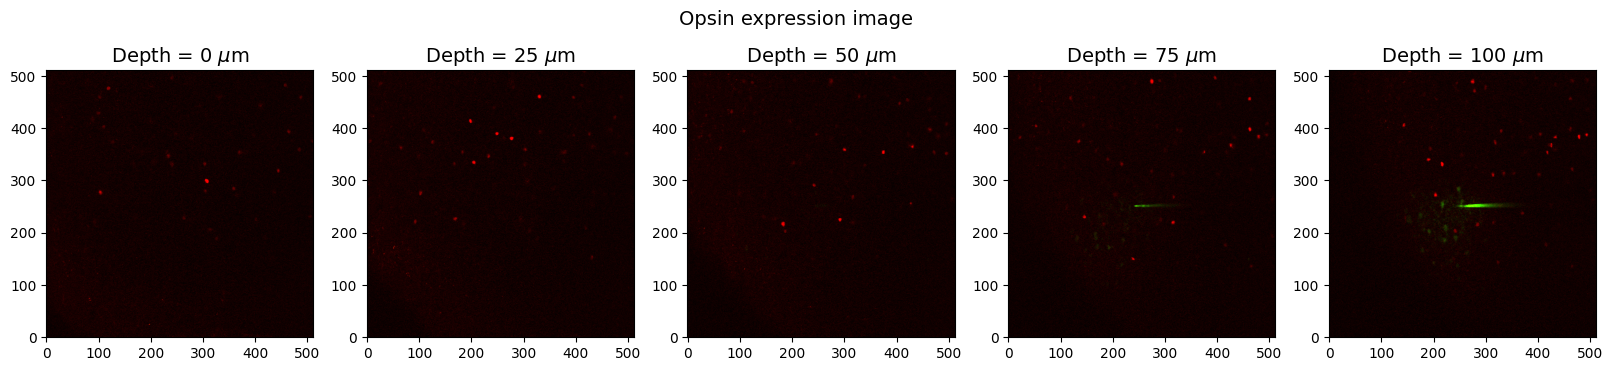

In [23]:
# Visualize stimulation FOV
img = np.array([f['mapping_stack'][0][i] for i in range(5)])

panel_size = 4
plt.figure(figsize=(5 * panel_size, 1 * panel_size))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i], origin='lower')
    plt.title('Depth = %i $\mu$m'%depths[i], fontsize=fontsize)
plt.suptitle('Opsin expression image', fontsize=fontsize)
plt.show()

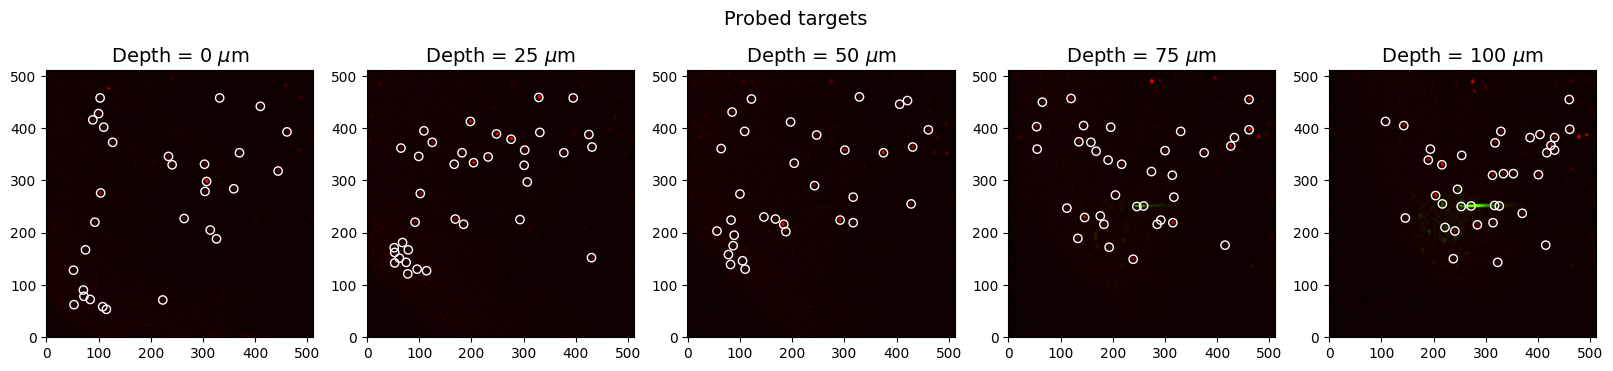

In [24]:
plt.figure(figsize=(5 * panel_size, 1 * panel_size))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img[i], origin='lower')
    locs = np.where(targets[:, -1] == depths[i])[0]
    plt.scatter(targets[locs, 1], targets[locs, 0], edgecolor='w', facecolor='None')
    plt.title('Depth = %i $\mu$m'%depths[i], fontsize=fontsize)
plt.suptitle('Probed targets', fontsize=fontsize)
    
plt.show()

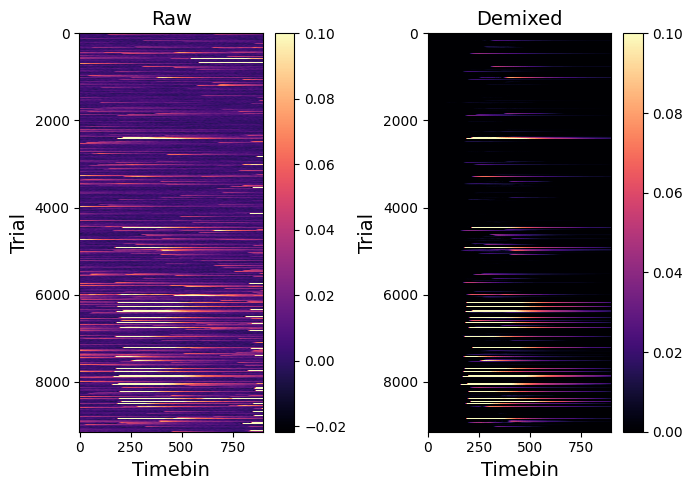

In [25]:
# Visualise overall removal of confounding currents by NWD

plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.imshow(pscs, aspect='auto', interpolation='nearest', cmap='magma', vmax=0.1)
plt.xlabel('Timebin', fontsize=fontsize)
plt.ylabel('Trial', fontsize=fontsize)
plt.title('Raw', fontsize=fontsize)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pscs_demixed, aspect='auto', interpolation='nearest', cmap='magma', vmax=0.1)
plt.xlabel('Timebin', fontsize=fontsize)
plt.ylabel('Trial', fontsize=fontsize)
plt.colorbar()
plt.title('Demixed', fontsize=fontsize)
plt.tight_layout()

plt.show()

In [26]:
# Setup model with default parameters
model_single, model_ensemble = cm.Model(N), cm.Model(N)

In [27]:
# Separate single-target and ensemble stimulation trials
single_tar_locs = np.where(np.sum(stimulus_matrix != 0, axis=0) == 1)[0]
ensemble_tar_locs = np.where(np.sum(stimulus_matrix != 0, axis=0) > 1)[0]

stim_single = stimulus_matrix[:, single_tar_locs]
stim_ensemble = stimulus_matrix[:, ensemble_tar_locs]

psc_dem_single = pscs_demixed[single_tar_locs]
psc_dem_ensemble = pscs_demixed[ensemble_tar_locs]

## Fit CAVIaR to data

In [28]:
# CAVIaR parameters
msrmp = 0.4 # minimum spike rate at maximum power
fit_options = {'iters': 50, 'save_histories': False, 'msrmp': msrmp}
method = 'caviar'

In [29]:
# Fit models
model_single.fit(psc_dem_single, stim_single, method=method, fit_options=fit_options)

Running coordinate-ascent variational inference and isotonic regularisation (CAVIaR) algorithm.


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


Examining 164/169 cells for false negatives...
Reconnecting cell 2 with maximal pava spike rate 0.50
Reconnecting cell 133 with maximal pava spike rate 0.42
Cell reconnection complete.


In [30]:
model_ensemble.fit(psc_dem_ensemble, stim_ensemble, method=method, fit_options=fit_options)

Running coordinate-ascent variational inference and isotonic regularisation (CAVIaR) algorithm.


100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Examining 165/169 cells for false negatives...
Reconnecting cell 105 with maximal pava spike rate 0.45
Reconnecting cell 133 with maximal pava spike rate 0.42
Reconnecting cell 2 with maximal pava spike rate 0.40
Cell reconnection complete.


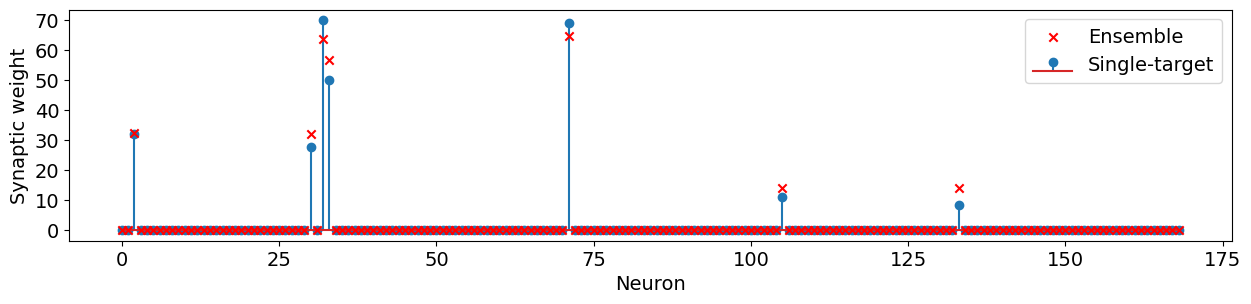


R2: 0.99


In [31]:
# Compare connections via stemplot

plt.figure(figsize=(15, 3))
plt.stem(np.arange(N), model_single.state['mu'], label='Single-target')
plt.scatter(np.arange(N), model_ensemble.state['mu'], marker='x', color='r', label='Ensemble', zorder=N)
plt.legend(fontsize=fontsize)
plt.xlabel('Neuron', fontsize=fontsize)
plt.ylabel('Synaptic weight', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

print('\nR2: %.2f'%r2_score(model_single.state['mu'], model_ensemble.state['mu']))

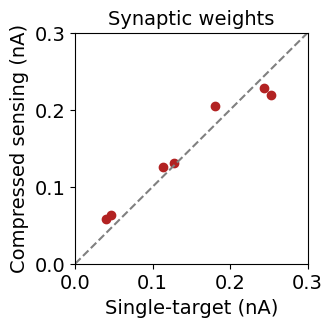

In [32]:
# Compute PSC amplitudes using ridge regression
ridge_waveforms_single = compute_ridge_waveforms(psc_dem_single, model_single.state, stim_single)
ridge_waveforms_ensemble = compute_ridge_waveforms(psc_dem_ensemble, model_ensemble.state, stim_ensemble)
amplitude_single, amplitude_ensemble = [np.max(arr, axis=1) for arr in [ridge_waveforms_single, ridge_waveforms_ensemble]]

plt.figure(figsize=(3, 3))
plt.scatter(amplitude_single, amplitude_ensemble, color='firebrick')
plt.title('Synaptic weights', fontsize=fontsize)
plt.plot([0, 0.3], [0, 0.3], '--', color='gray')
plt.xlabel('Single-target (nA)', fontsize=fontsize)
plt.ylabel('Compressed sensing (nA)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([0, 0.3])
plt.yticks(np.arange(0, 0.31, 0.1))
plt.xlim([0, 0.3])
plt.xticks(np.arange(0, 0.31, 0.1))
plt.show()

## Checkerboard visualization

In [33]:
den_pscs = [psc_dem_single, psc_dem_ensemble]
stim_matrices = [stim_single, stim_ensemble]
models = [model_single.state, model_ensemble.state]
titles = ['Single-target stimulation', 'Ensemble stimulation']
trials = 60
row_height = 0.35
ymax = 0.85
col_widths = np.array([8, 12])

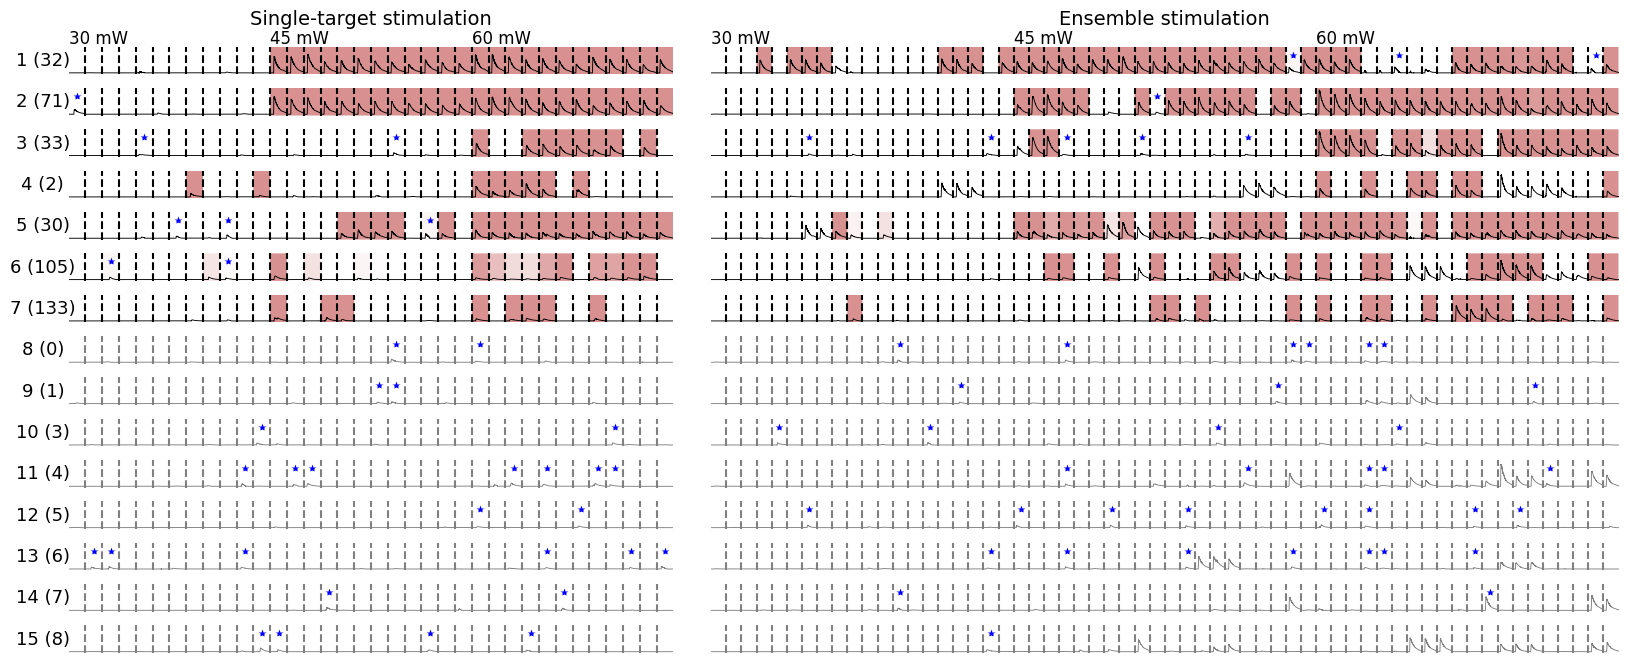

In [34]:
viz.plot_spike_inference_comparison(den_pscs, stim_matrices, models, titles=titles, max_trials_to_show=trials, col_widths=col_widths, ymax=ymax, row_height=row_height)

### Visualize connections

In [35]:
def get_plot_cols(locs):
    cmap = matplotlib.cm.get_cmap('plasma')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(locs))
    rord = np.random.choice(len(locs), len(locs), replace=False)
    return cmap, norm, rord

In [36]:
psc_single = pscs[single_tar_locs]
psc_ensemble = pscs[ensemble_tar_locs]

In [37]:
example_neuron = 71 # connection to visualize

In [38]:
# random subset of traces
subset = np.random.choice(np.where(stim_ensemble[example_neuron])[0], stim_reps, replace=False)

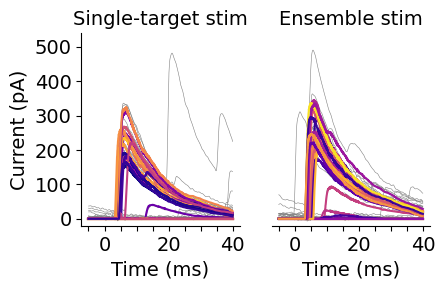

In [39]:
# identify relevant trials
locs = np.where(stim_single[example_neuron])[0]
ymax = np.max([np.max(psc_ensemble[subset]), np.max(psc_single[locs])]) * pA
ylim = [ymin, 1.1 * ymax]

cmap, norm, rord = get_plot_cols(subset)

plt.figure(figsize=(4.5, 2.5))
plt.subplot(1, 2, 1)
plt.plot(xs, psc_ensemble[subset].T * pA, color='gray', linewidth=0.4)
for indx in range(stim_reps):
    plt.plot(xs, psc_dem_ensemble[subset[indx]] * pA, color=cmap(norm(rord[indx])), linewidth=1.5)
plt.xticks(xticks, fontsize=fontsize)
plt.gca().set_xticklabels(xticklabels)
plt.ylim(ylim)
plt.yticks(fontsize=fontsize)
plt.ylabel('Current (pA)', fontsize=fontsize)
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.title('Single-target stim', fontsize=fontsize)
for loc in ['top', 'right']:
    plt.gca().spines[loc].set_visible(False)

plt.subplot(1, 2, 2)
cmap, norm, rord = get_plot_cols(locs)
plt.plot(xs, psc_single[locs].T * pA, color='gray', linewidth=0.4)
for indx in range(stim_reps):
    plt.plot(xs, psc_dem_single[locs[indx]] * pA, color=cmap(norm(rord[indx])), linewidth=1.5)
plt.ylim(ylim)
plt.yticks([])
plt.xticks(xticks, fontsize=fontsize)
plt.gca().set_xticklabels(xticklabels)
for loc in ['top', 'right', 'left']:
    plt.gca().spines[loc].set_visible(False)
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.title('Ensemble stim', fontsize=fontsize)

plt.show()